In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d
import time

nside = 1024
lmax = 1024*3-1

def iqu2teb(IQU, nside, lmax=None):
    print('a')
    alms = hp.map2alm(IQU, lmax=lmax, pol=True)
    print('b')
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=False)

def teb2iqu(TEB, nside, lmax=None):
    alms = hp.map2alm(TEB, lmax=lmax, pol=False)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=True)

# Begin in Q, U 
### $a_{Q,U} = R \ a_{E,B} + n_{Q,U}$
### $d_{Q,U} = s_{Q,U} + n_{Q,U}$ 
### $\boldsymbol{d} = \boldsymbol{s} + \boldsymbol{n}$


# Algorithm
### $t = T/(T+N) \ d + \bar{N}/(\bar{N} + T) \  s $
### $ s = S/(S+T) \ t $


# Definitions
### $N_{Q,U} = \langle n_{Q,U} n_{Q,U}^\dagger  \rangle $
### $\bar{N} = N - T$
### $ T = \tau \times \mathbf{1}$ , where $\tau = {\rm{min}} \big( N \big)$

# Signal covariance

In [2]:
# ell_ee, cell_ee = np.load('data/namaster_buzzard.npy')
# cell_func = interp1d(np.hstack([ell_ee, [ell_ee[-1]+1,1e4]]),
#                      np.hstack([cell_ee, [cell_ee[-10]*0.5,1e-15]]),
#                      fill_value='extrapolate', kind='linear')

In [3]:
# _ = plt.loglog(ell_ee, cell_ee* ell_ee *(ell_ee+1), linewidth=3)
# _  =plt.ylabel(r'$C_\ell \ \ell \ (\ell+1)$')
# _  =plt.xlabel(r'$C_\ell \ \ell \ (\ell+1)$')
# _ = plt.title(r'Namaster pseudo-$C_\ell$ from Buzzard')
# ell_cov, mmm_cov = hp.Alm.getlm(nside*3-1)
# s_cov_diag =  cell_func(ell_cov)

In [4]:
s_cov_diag = np.load('s_cov_EE_1024.npy')

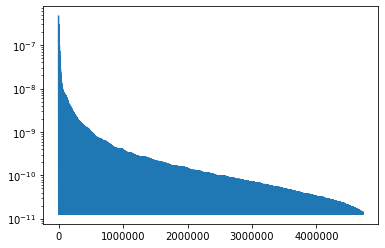

In [5]:
_ = plt.plot(s_cov_diag), plt.yscale('log')

# Data

In [6]:
data_QU = hp.read_map('./map_mock_des1024_QU.fits', field=(0,1))
data_vec = data_QU[0] + 1j* data_QU[1]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


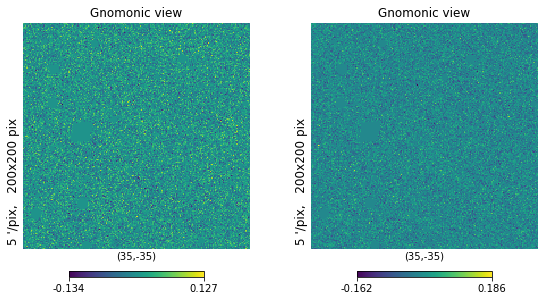

In [7]:
_ = plt.figure(figsize = (12,4)), hp.gnomview(data_vec.real, sub=(1,3,2), reso=5, rot = (35,-35))
_ = hp.gnomview(data_vec.imag, sub=(1,3,3), reso=5, rot = (35,-35))

# Noise covariance

In [8]:
noise_diag = hp.read_map('map_noise_cov_des1024_QU.fits', field=(0,1))
noise_diag = noise_diag[0] + noise_diag[1]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


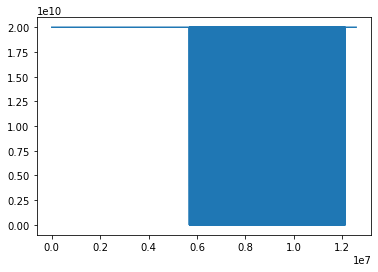

In [9]:
plt.plot(noise_diag)

In [10]:
tau = np.min(noise_diag)
print(tau)
T_pixel = np.ones(noise_diag.shape)*tau
T_harmonic = np.ones(hp.map2alm(data_QU[0], lmax=nside*3-1).shape)*T_pixel[0] / np.float(nside*nside)
print(T_harmonic[0])

0.00034328451147302985
3.2738162181189523e-10


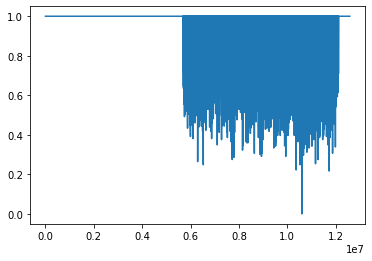

In [11]:
noise_bar_diag = noise_diag - tau
plt.plot(noise_bar_diag/(noise_bar_diag+T_pixel))

# Algorithm

In [13]:
n_iter = 50
s = np.zeros(data_vec.shape, dtype='complex')


T_harmonic_grade = np.ones(hp.map2alm(hp.ud_grade(data_QU[0],1024),
                                      lmax=1024*3-1).shape)*T_pixel[0] / np.float(1024*1024)

s_cov_diag_grade = s_cov_diag # cell_func(hp.Alm.getlm(1024*3-1)[0])
# s_cov_diag

harmonic_operator = (s_cov_diag_grade/(s_cov_diag_grade+T_harmonic_grade))
pixel_operator_signal = (noise_bar_diag/(noise_bar_diag+T_pixel))
pixel_operator_data = (T_pixel / (T_pixel + noise_diag))

for i in range(n_iter):
    
    t = pixel_operator_data * data_vec + pixel_operator_signal*s
#     t = hp.ud_grade(t,512)
    
    t_alm1 = hp.map2alm(t.real, lmax = 3*1024-1) 
    t_alm2 = hp.map2alm(t.imag, lmax = 3*1024-1) 
    
    s1 = hp.alm2map(harmonic_operator * t_alm1, nside=1024, lmax=1024*3-1, verbose=False)
    s2 = hp.alm2map(harmonic_operator * t_alm2, nside=1024, lmax=1024*3-1, verbose=False)
    
    s = s1 +1j*s2
    
#     s = hp.ud_grade(s, 128)
#     _ = hp.mollview(s.imag), plt.show()
    print(np.var(s))

1.2467874651899837e-07
2.338849877452962e-07
3.084684695490474e-07
3.6136192148722064e-07
3.997875646027102e-07
4.281059154724633e-07
4.4918408523412573e-07
4.649996530764844e-07
4.769527223318417e-07
4.860499298616537e-07
4.930224304761087e-07
4.984053205450542e-07
5.025926388896177e-07
5.058761230709323e-07
5.084728381461181e-07
5.105450412702692e-07
5.122145612827442e-07
5.135732680680707e-07
5.146907342724415e-07
5.15619868821519e-07
5.164010774417096e-07
5.170653481723687e-07
5.176365487515008e-07
5.181331437173459e-07
5.185694825129875e-07
5.189567692028978e-07
5.193037950099071e-07
5.196174935350262e-07
5.19903362956979e-07
5.2016578811107e-07
5.204082869684683e-07
5.206336998544104e-07
5.208443351647161e-07
5.210420819367671e-07
5.212284970930708e-07
5.214048732768452e-07
5.21572291773947e-07
5.217316639429596e-07
5.218837637654462e-07
5.220292535155022e-07
5.221687040825623e-07
5.223026111273726e-07
5.224314079810541e-07
5.225554759906652e-07
5.226751528563955e-07
5.2279073938

In [14]:
np.var(s_eb1[1])

NameError: name 's_eb1' is not defined

In [15]:
s_eb1 = iqu2teb([s*0.,s.real,s.imag], nside, lmax=nside*3-1)

a


/Users/ucapnje/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  pixel_weights_filename=pixel_weights_filename,


b
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


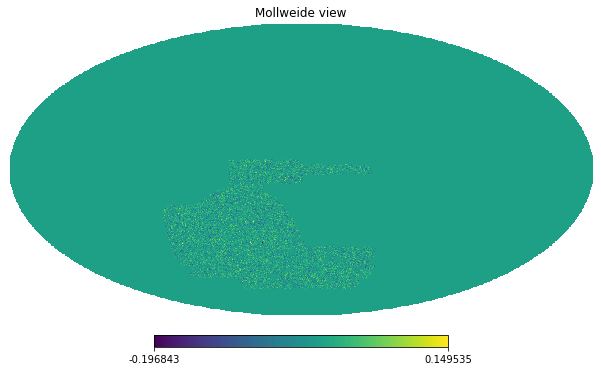

In [16]:
hp.mollview(data_vec.imag)

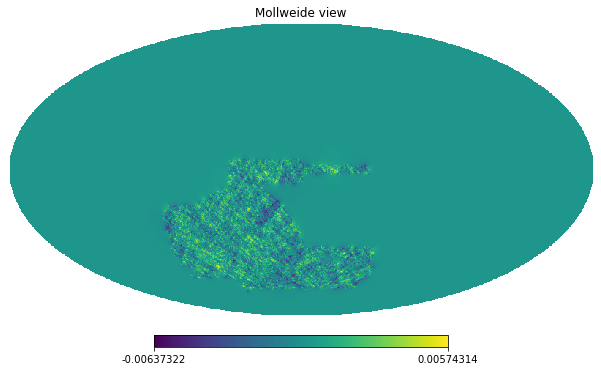

In [17]:
hp.mollview(s.imag)

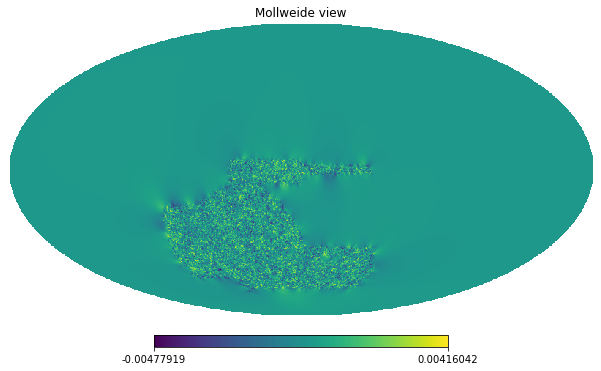

In [39]:
hp.mollview(s_eb1[2])

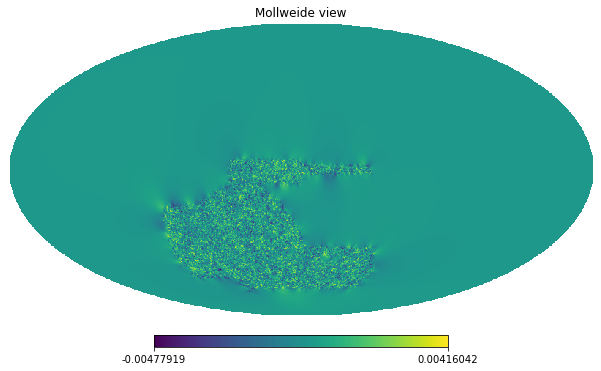

In [19]:
hp.mollview(s_eb1[2])

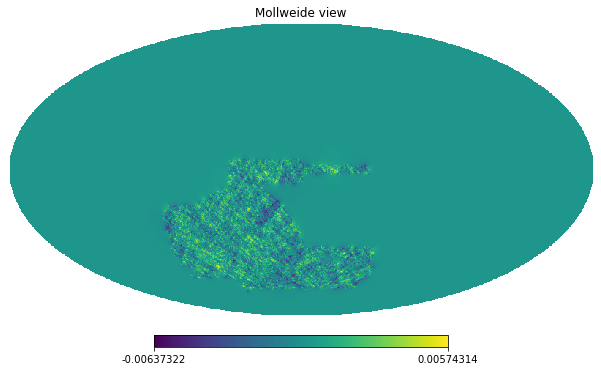

In [37]:
hp.mollview(s.imag)

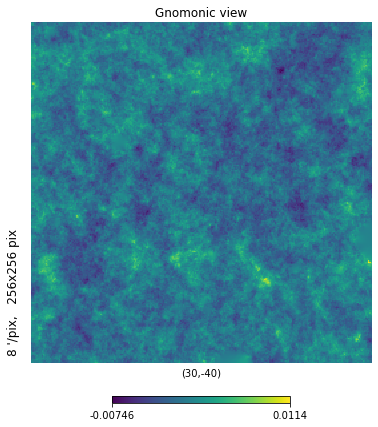

In [21]:
hp.gnomview(s_eb1[1], reso = 8, rot=(30,-40), xsize = 256)

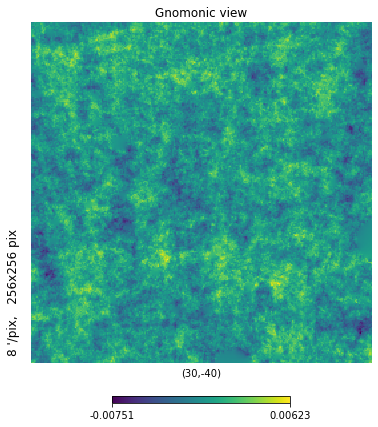

In [22]:
hp.gnomview(s.real, reso = 8, rot=(30,-40), xsize = 256)

In [ ]:
# np.save('test_wiener180320', s)

In [23]:
np.save('test_wiener1_E_230320', np.array(s_eb1[1], dtype = 'float'))

In [28]:
test_map_eb2 = np.load('test_wiener2_E_230320.npy')

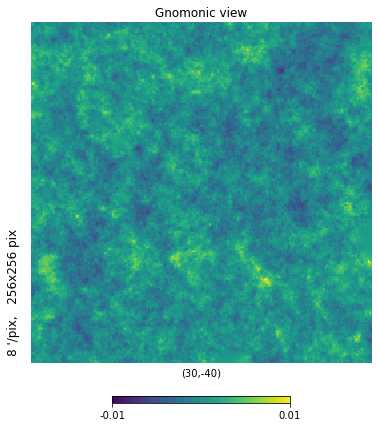

In [29]:
hp.gnomview(s_eb1[1], reso = 8, rot=(30,-40), xsize = 256, min=-0.01, max=0.01)

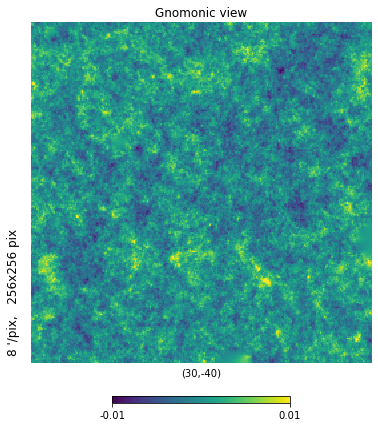

In [30]:
hp.gnomview(test_map_eb2, reso = 8, rot=(30,-40), xsize = 256, min=-0.01, max=0.01)

In [ ]:
hp.gnomview(test_map_eb2-s_eb1[1], reso = 8, rot=(30,-40), xsize = 256, min=-0.005, max=0.005)

In [32]:
f_sky = 0.126087983449
cl_method1 = (1./f_sky) * hp.anafast(s_eb1[1])
cl_method2 = (1./f_sky) * hp.anafast(test_map_eb2)

In [40]:
cl_3 =  (1./f_sky) * hp.anafast(s_eb1[2])

In [41]:
ell = np.arange(cl_method1.shape[0])

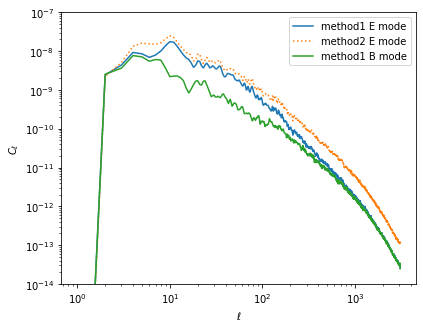

In [47]:
_ = plt.figure(figsize = (14,5))
_ = plt.subplot(1,2,1)
_ = plt.loglog(ell,cl_method1, label='method1 E mode')
_ = plt.loglog(ell,cl_method2, ':', label='method2 E mode')
_ = plt.loglog(ell,cl_3, '-', label='method1 B mode')
# _ = plt.loglog(ell,cl_method1+cl_3, '--', label='method3+1')
_ = plt.ylim(1e-14,1e-7), plt.legend()
_ = plt.ylabel(r'$C_\ell\ $'), plt.xlabel(r'$\ell$')

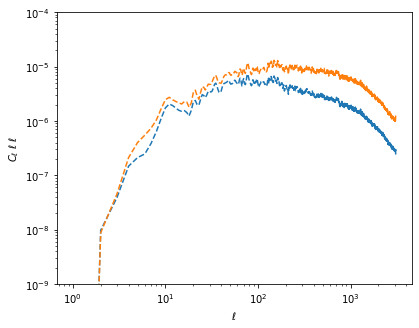

In [36]:
_ = plt.figure(figsize = (14,5))
_ = plt.subplot(1,2,1)
_ = plt.loglog(ell,cl_method1*ell*ell, , label='method1')
_ = plt.loglog(ell,cl_method2*ell*ell, ':', label='method2')
_ = plt.loglog(ell,cl_method2*ell*ell, '-', label='method3')
_ = plt.loglog(ell,cl_method2+)*ell*ell, '--', label='method3+1')
_ = plt.ylim(1e-9,1e-4)
_ = plt.ylabel(r'$C_\ell\ \ell \ \ell$'), plt.xlabel(r'$\ell$')

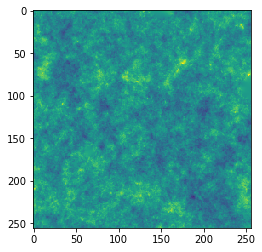

In [31]:
projected_wiener = hp.gnomview(s_eb1[1], reso = 8, rot=(30,-40),
                       xsize = 256,return_projected_map=True), plt.close()
projected_wiener = projected_wiener[0]
plt.imshow(projected_wiener.data ,clim=(-0.01, 0.01))
np.save('projected_wiener1',projected_wiener.data)

In [ ]:
truth = 